In [2]:
import json
import os.path as op
from utilities import files
from mne import read_epochs, pick_channels
import numpy as np
import pandas as pd
from os import sep
import itertools as it
import matplotlib.pylab as plt
from matplotlib.collections import LineCollection
from matplotlib import colors
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm.notebook import trange, tqdm
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_test, permutation_cluster_test, ttest_1samp_no_p
from scipy.stats import kruskal, linregress, kendalltau, t, norm, distributions
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from joblib import Parallel, delayed
from functools import partial
from copy import deepcopy
from skimage.measure import find_contours
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline

In [3]:
def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)


def cat(options, target):
    for i in options:
        if i in target:
            return i


def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array


def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def consecutive_margin_ix(data, step=1):
    ixs = np.split(data, np.where(np.diff(data) != step)[0]+1)
    ret = []
    for ix in ixs:
        start = ix[0]-1
        stop = ix[-1]+1
        if start < 0:
            start = 0
        ret.append([start, stop])
    return ret


In [4]:
motor_epo = read_epochs("/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-101/sub-101-008-motor-epo.fif", verbose=False)
motor_epo = motor_epo.pick_types(meg=True, ref_meg=False, misc=False)
motor_epo_times = motor_epo.times
motor_epo = motor_epo.info
visual_epo = read_epochs("/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-101/sub-101-008-visual-epo.fif", verbose=False)
visual_epo = visual_epo.pick_types(meg=True, ref_meg=False, misc=False)
visual_epo_times = visual_epo.times
visual_epo = visual_epo.info
burst_times = np.linspace(-0.1,0.1, num=120)

sensors = [i for i in motor_epo["ch_names"] if many_is_in(["MLC"], i)]
sensors = [i for i in sensors if not many_is_in(["MLC1", "MLC25", "MLC32", "MLC42", "MLC54", "MLC55", "MLC63"], i)]

In [8]:
path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed"
subs = files.get_folders_files(path)[0]
subs = [op.join(i, "bursts") for i in subs]
subs = [i for i in subs if op.exists(i)]
subs.sort()

json_files = {}
for sub in subs:
    sub_id = sub.split(sep)[-2]
    subs_bursts = files.get_files(sub, "", ".json")[2]
    subs_bursts = [i for i in subs_bursts if many_is_in(sensors, i)]
    subs_bursts.sort()
    json_files[sub_id] = subs_bursts

all_files = [y for i in json_files.keys() for y in json_files[i]]
waveforms = []
for json_file in tqdm(all_files):
    with open(json_file) as pipeline_file:
        bs = json.load(pipeline_file)
    am_bs = len(bs["waveform"])
    bs_samp_ix = np.random.choice(np.arange(am_bs), int(am_bs*0.2))
    bs_samp = np.vstack(bs['waveform'])[bs_samp_ix, :]
    waveforms.append(bs_samp)

waveforms = np.vstack(waveforms)

waveforms_medians = np.median(waveforms, axis=1)
clean_ixs = np.where((waveforms_medians > np.percentile(waveforms_medians, 10)) & (waveforms_medians < np.percentile(waveforms_medians, 90)))[0]
waveforms_clean = waveforms[clean_ixs]

scaler = RobustScaler().fit(waveforms_clean)
waveforms_scaled = scaler.transform(waveforms_clean)

pca_full = PCA(n_components=20)
pcs_full = pca_full.fit_transform(waveforms_scaled)

  0%|          | 0/792 [00:00<?, ?it/s]

In [9]:
PCS_to_analyse = 18
mean_waveform = np.mean(waveforms, axis=0)
norm_mean = mean_waveform/np.max(mean_waveform)

In [10]:
sub_metrics = {}
for sub in tqdm(json_files.keys()):
    print(sub)
    all_files = json_files[sub]
    metrics = {
        "vis": {
            "waveform": [],
            "peak_time": [],
            "peak_freq": [],
            "peak_amp_base": [],
            "fwhm_freq": [],
            "fwhm_time": [],
            "trial": [],
            "pp_ix": [],
            "block" : []
        },
        "mot": {
            "waveform": [],
            "peak_time": [],
            "peak_freq": [],
            "peak_amp_base": [],
            "fwhm_freq": [],
            "fwhm_time": [],
            "trial": [],
            "pp_ix": [],
            "block" : []
        }
    }

    for json_file in all_files:
        big_key = [i for i in ["mot", "vis"] if i in json_file][0]
        with open(json_file) as pipeline_file:
            bs = json.load(pipeline_file)
        wf = np.array(bs['waveform'])
        wf_median = np.median(wf, axis=1)
        wf_ixs = np.where(
            (wf_median > np.percentile(waveforms_medians, 1)) & 
            (wf_median < np.percentile(waveforms_medians, 99))
        )[0]

        wf = wf[wf_ixs,:]
        metrics[big_key]["waveform"].append(wf)
        for k in ["peak_time", "peak_amp_base", "fwhm_freq", "fwhm_time", "peak_freq", "trial", "pp_ix", "block"]:
            metrics[big_key][k].append(np.array(bs[k])[wf_ixs])      

    for i in ["mot", "vis"]:
        metrics[i]["waveform"] = np.vstack(metrics[i]["waveform"])
        for k in ["peak_time", "peak_amp_base", "fwhm_freq", "fwhm_time", "peak_freq", "trial", "pp_ix", "block"]:
            metrics[i][k] = np.hstack(metrics[i][k])
    sub_metrics[sub] = metrics

  0%|          | 0/36 [00:00<?, ?it/s]

sub-101
sub-102
sub-103
sub-106
sub-107
sub-108
sub-109
sub-110
sub-111
sub-112
sub-113
sub-114
sub-117
sub-118
sub-119
sub-120
sub-122
sub-123
sub-124
sub-126
sub-127
sub-129
sub-130
sub-131
sub-132
sub-133
sub-134
sub-135
sub-136
sub-139
sub-140
sub-141
sub-142
sub-143
sub-144
sub-145


In [11]:
time_buf = 0.125
bin_width = 0.05
smooth_kernel_size = 1
vis_time_bins = np.arange(visual_epo_times[0]+time_buf, visual_epo_times[-1]-time_buf, bin_width)
mot_time_bins = np.arange(motor_epo_times[0]+time_buf, motor_epo_times[-1]-time_buf, bin_width)

burst_base_bins = np.where(vis_time_bins<0)[0]

results_all = {str(i): {"vis": [], "mot": []} for i in range(PCS_to_analyse)}

for sub in tqdm(sub_metrics.keys()):
    trials_vis = np.unique(sub_metrics[sub]["vis"]["pp_ix"])
    trials_mot = np.unique(sub_metrics[sub]["mot"]["pp_ix"])

    score_mot = pca_full.transform(scaler.transform(sub_metrics[sub]["mot"]["waveform"]))
    score_vis = pca_full.transform(scaler.transform(sub_metrics[sub]["vis"]["waveform"]))
    for comp in range(PCS_to_analyse):
        comp_score = score_vis[:, comp]
        score_range = np.linspace(
            np.percentile(comp_score, 1),
            np.percentile(comp_score, 99),
            num = 41
        )
        
        mv_burst_rate = np.zeros((len(trials_vis), len(vis_time_bins)-1, len(score_range)-1))
        for ix, t_ix in enumerate(trials_vis):
            ixes = np.where(sub_metrics[sub]["vis"]["pp_ix"] == t_ix)
            mv_hist, t_bin_edges, m_bin_edges = np.histogram2d(
                sub_metrics[sub]["vis"]["peak_time"][ixes],
                comp_score[ixes], 
                bins=[vis_time_bins, score_range]
            )
            mv_hist = mv_hist / bin_width
            mv_burst_rate[ix,:,:] = gaussian_filter(mv_hist,[smooth_kernel_size,smooth_kernel_size])
        mv = np.mean(mv_burst_rate,axis=0)
        

        comp_score = score_mot[:, comp]
        score_range = np.linspace(
            np.percentile(comp_score, 0.5),
            np.percentile(comp_score, 99.5),
            num=41
        )
        

        mm_burst_rate = np.zeros((len(trials_mot), len(mot_time_bins)-1, len(score_range)-1))
        for ix, t_ix in enumerate(trials_mot):
            ixes = np.where(sub_metrics[sub]["mot"]["pp_ix"] == t_ix)
            mm_hist, t_bin_edges, m_bin_edges = np.histogram2d(
                sub_metrics[sub]["mot"]["peak_time"][ixes],
                comp_score[ixes], 
                bins=[mot_time_bins, score_range]
            )
            mm_hist = mm_hist / bin_width
            mm_burst_rate[ix,:,:] = gaussian_filter(mm_hist,[smooth_kernel_size,smooth_kernel_size])
        mm = np.mean(mm_burst_rate,axis=0)

        base_bursts = np.mean(mv[burst_base_bins[1:],:],axis=0).reshape(1,-1)
        mv = (mv - base_bursts) / base_bursts
        mm = (mm - base_bursts) / base_bursts
        
        results_all[str(comp)]["vis"].append(mv)
        results_all[str(comp)]["mot"].append(mm)

  0%|          | 0/36 [00:00<?, ?it/s]

In [232]:
threshold_tfce = dict(start=0, step=0.2)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)


numx = PCS_to_analyse
# numx = 2
f, ax = plt.subplots(numx, 3, figsize=(10, numx*3+3), facecolor="white", dpi=300, gridspec_kw={'width_ratios': [0.4, 2.15, 1.65]})
for comp in trange(numx):
    mv_a = np.array(results_all[str(comp)]["vis"])
    mm_a = np.array(results_all[str(comp)]["mot"])

    #### STAAATS
    # stats TFCE + "hat" variance adjustment + FWER https://doi.org/10.1016/j.neuroimage.2011.10.027
    # https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html#visualize-and-compare-methods
    # Clustering with TFCE and "hat" variance adjustment narrows down the area declared significant

    mv_T_HAT, _, mv_P_HAT, _ = permutation_cluster_1samp_test(
        mv_a, stat_fun=hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    mv_mask = np.reshape(mv_P_HAT, mv.shape).T
    mv_mask[mv_mask >= 0.05] = 1
    mv_mask[mv_mask < 0.05] = np.nan
    
    mm_T_HAT, _, mm_P_HAT, _ = permutation_cluster_1samp_test(
        mm_a, stat_fun=hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    mm_mask = np.reshape(mm_P_HAT, mm.shape).T
    mm_mask[mm_mask >= 0.05] = 1
    mm_mask[mm_mask < 0.05] = np.nan
    ####

    mv = np.mean(mv_a, axis=0)
    mm = np.mean(mm_a, axis=0)
        
    all_burst_im = np.vstack([mv, mm])
    lims = [-np.max(np.abs(all_burst_im[:])), np.max(np.abs(all_burst_im[:]))]
    divnorm = colors.TwoSlopeNorm(vmin=lims[0], vcenter=0, vmax=lims[1])
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    
    for key, spine in ax[comp, 0].spines.items():
        spine.set_visible(False)
    ax[comp, 0].set_yticks([])
    ax[comp, 0].set_xticks([])
    ax[comp, 0].set_ylabel("PC {} Burst shapes".format(comp+1))

    col_r = plt.cm.cool(np.linspace(0,1,4))
    poss = np.linspace(int(score_range[0])+0.25, int(score_range[-1])-0.25, 4)
    for ixxx, pos in enumerate(poss):
        burst_shape = (norm_mean + pos * pca_full.components_[comp,:]) / 2 + pos
        ax[comp, 0].plot(burst_times, burst_shape, c=col_r[ixxx])
    ax[comp, 0].set_ylim(score_range[0], score_range[-1])
    
    v_im = ax[comp, 1].imshow(mv.T, cmap="RdBu_r", origin="lower", norm=divnorm, extent=[vis_time_bins[0], vis_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none", rasterized=True)
    ax[comp, 1].imshow(mv_mask,cmap="gray_r", origin="lower", norm=graynorm, extent=[vis_time_bins[0], vis_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    
    m_im = ax[comp, 2].imshow(mm.T, cmap="RdBu_r", origin="lower", norm=divnorm, extent=[mot_time_bins[0], mot_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none", rasterized=True)
    ax[comp, 2].imshow(mm_mask,cmap="gray_r", origin="lower", norm=graynorm, extent=[mot_time_bins[0], mot_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

    ax[comp, 2].set_yticks([])

    cbar = plt.colorbar(m_im, ax=ax[comp, 2])
    cbar.set_label("Rate", rotation=90)

plt.tight_layout()
plt.savefig("BURST_SUMMARY_avec_stats.svg")

  0%|          | 0/18 [00:00<?, ?it/s]

In [97]:
PCA_divided = {
   sub: {
       "mot": pca_full.transform(scaler.transform(sub_metrics[sub]["mot"]["waveform"])),
       "vis": pca_full.transform(scaler.transform(sub_metrics[sub]["vis"]["waveform"]))
   } for sub in sub_metrics.keys()
}

time_buf = 0.125
bin_width = 0.05
smooth_kernel_size = 1
vis_time_bins = np.arange(visual_epo_times[0]+time_buf, visual_epo_times[-1]-time_buf, bin_width)
mot_time_bins = np.arange(motor_epo_times[0]+time_buf, motor_epo_times[-1]-time_buf, bin_width)

In [98]:
nice_results = {
    sub: {
        pc: {"vis": [], "mot": []} for pc in range(PCS_to_analyse)
    } for sub in sub_metrics.keys()
}

def do_it(trial_ix, trials, comp, comp_score, sub, sub_metrics, vis_mot_key, time_bins):
    TC = []
    for t in list(zip(time_bins[:-1], time_bins[1:])):
        t_ixes = (
            (sub_metrics[sub][vis_mot_key]["peak_time"] > t[0]) & 
            (sub_metrics[sub][vis_mot_key]["peak_time"] < t[1]) & 
            (sub_metrics[sub][vis_mot_key]["pp_ix"] == trials[trial_ix])
        )
        TC.append(np.nanmean(comp_score[t_ixes]))
    TC = np.array(TC)
    nice_results[sub][comp][vis_mot_key].append(TC)

for sub in tqdm(list(sub_metrics.keys()), colour="#6a0dad", desc="subject"):
    trials_vis = np.unique(sub_metrics[sub]["vis"]["pp_ix"])
    trials_mot = np.unique(sub_metrics[sub]["mot"]["pp_ix"])
    for comp in trange(PCS_to_analyse):
        comp_score_vis = PCA_divided[sub]["vis"][:, comp]
        comp_score_mot = PCA_divided[sub]["mot"][:, comp]
        
        Parallel(n_jobs=-1, require="sharedmem")(delayed(do_it)(
            tix, trials_vis, comp, comp_score_vis, sub, sub_metrics, "vis", vis_time_bins
        ) for tix in range(len(trials_vis)))
        
        Parallel(n_jobs=-1, require="sharedmem")(delayed(do_it)(
            tix, trials_mot, comp, comp_score_mot, sub, sub_metrics, "mot", mot_time_bins
        ) for tix in range(len(trials_mot)))
        
        nice_results[sub][comp]["vis"] = np.nanmean(np.vstack(nice_results[sub][comp]["vis"]), axis=0)
        nice_results[sub][comp]["mot"] = np.nanmean(np.vstack(nice_results[sub][comp]["mot"]), axis=0)

subject:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [100]:
permutation_variance_results = {
    pc: {"vis": [], "mot": []} for pc in range(PCS_to_analyse)
}

def do_it_perm(trial_ix, trials, comp, comp_score, sub, sub_metrics, vis_mot_key, time_bins, OUT):
    pp_ixes = np.where(sub_metrics[sub][vis_mot_key]["pp_ix"] == trials[trial_ix])[0]
    TC = []
    for t in list(zip(time_bins[:-1], time_bins[1:])):
        t_ixes = (
            (sub_metrics[sub][vis_mot_key]["peak_time"] > t[0]) &
            (sub_metrics[sub][vis_mot_key]["peak_time"] < t[1]) &
            (sub_metrics[sub][vis_mot_key]["pp_ix"] == trials[trial_ix])
        )
        TC.append(np.nanmean(comp_score[t_ixes]))
    TC = np.array(TC)
    OUT.append(TC)

    
for comp in trange(PCS_to_analyse, colour="#6a0dad", desc="component"):
    for _ in trange(100, desc="PERMUTATIONS"):
        VAR_vis = []
        VAR_mot = []
        for sub in list(sub_metrics.keys()):
            trials_vis = np.unique(sub_metrics[sub]["vis"]["pp_ix"])
            trials_mot = np.unique(sub_metrics[sub]["mot"]["pp_ix"])
            comp_score_vis = deepcopy(PCA_divided[sub]["vis"][:, comp])
            np.random.shuffle(comp_score_vis)
            comp_score_mot = deepcopy(PCA_divided[sub]["mot"][:, comp])
            np.random.shuffle(comp_score_mot)
            VIS_TR = []
            MOT_TR = []
            Parallel(n_jobs=-1, require="sharedmem")(delayed(do_it_perm)(
                tix, trials_vis, comp, comp_score_vis, sub, sub_metrics, "vis", vis_time_bins, VIS_TR
            ) for tix in range(len(trials_vis)))

            Parallel(n_jobs=-1, require="sharedmem")(delayed(do_it_perm)(
                tix, trials_mot, comp, comp_score_mot, sub, sub_metrics, "mot", mot_time_bins, MOT_TR
            ) for tix in range(len(trials_mot)))

            VAR_vis.append(np.var(np.nanmean(np.vstack(VIS_TR), axis=0)))
            VAR_mot.append(np.var(np.nanmean(np.vstack(MOT_TR), axis=0)))
        permutation_variance_results[comp]["vis"].append(np.mean(VAR_vis))
        permutation_variance_results[comp]["mot"].append(np.mean(VAR_mot))

component:   0%|          | 0/18 [00:00<?, ?it/s]

PERMUTATIONS:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


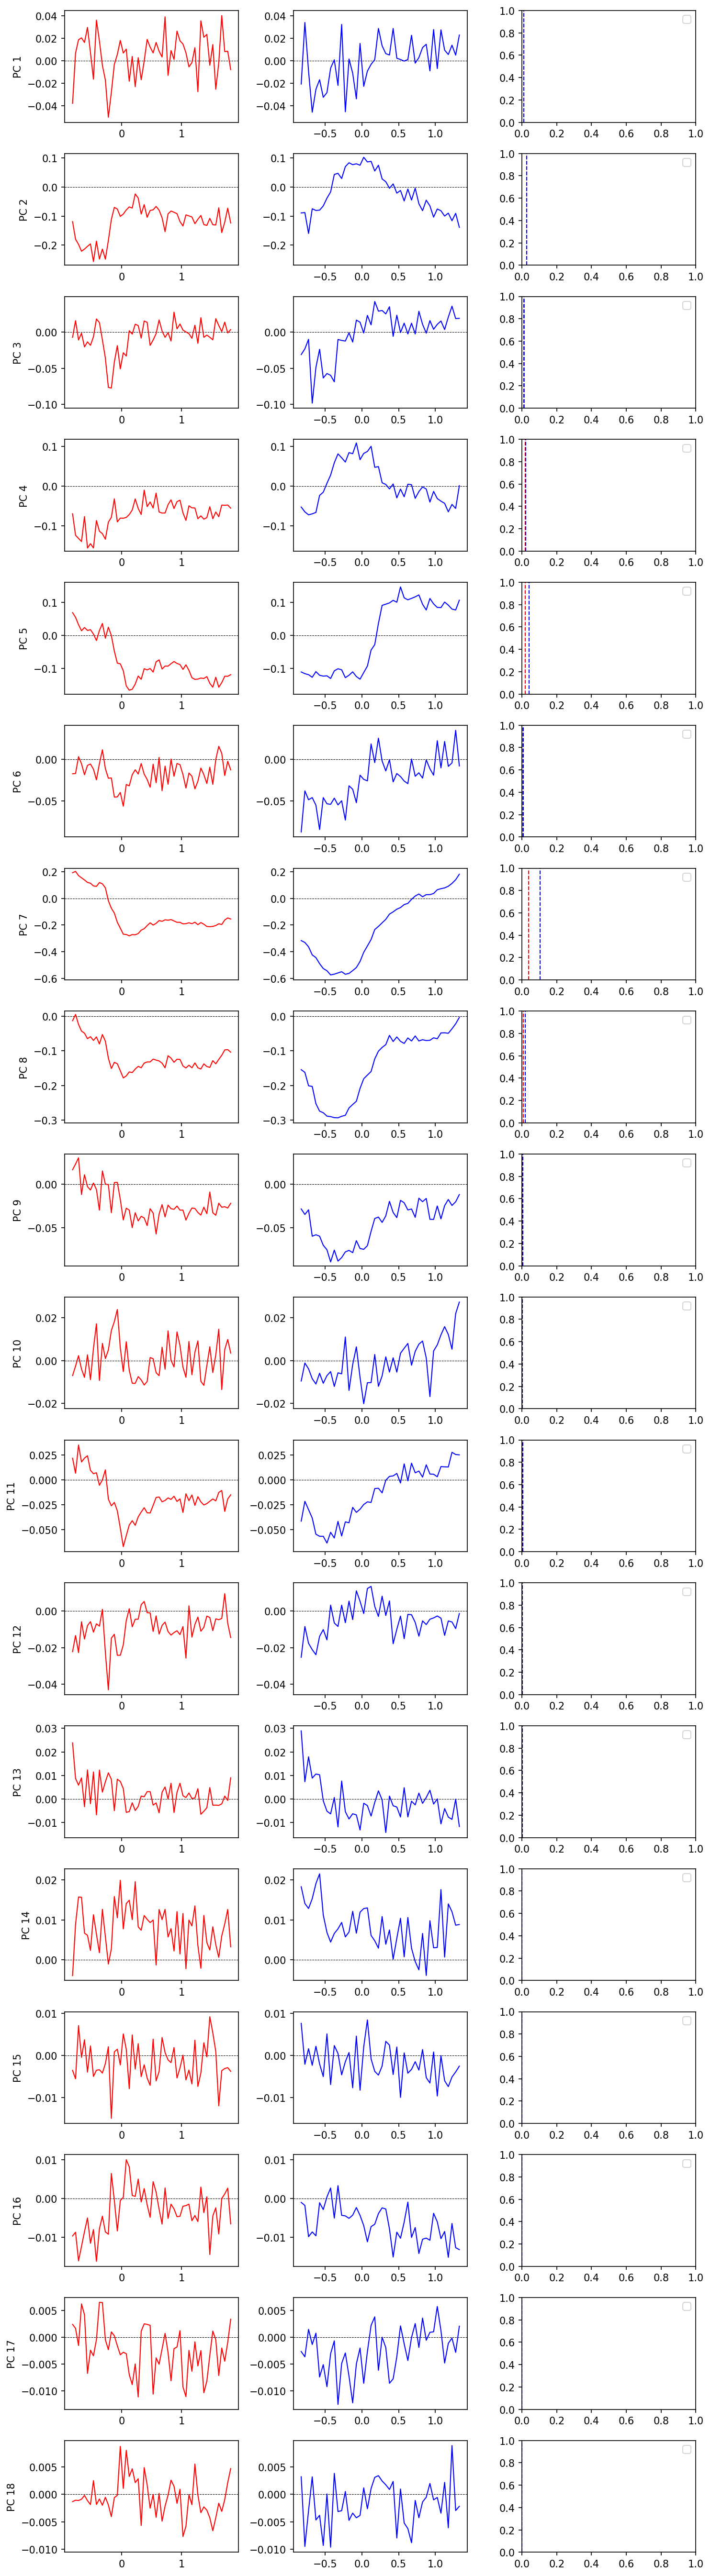

In [131]:
numx = PCS_to_analyse
f, ax = plt.subplots(numx, 3, figsize=(10, numx*2), facecolor="white", dpi=150)

for ix, comp in enumerate(range(numx)):
    vis_avg_tc = []
    mot_avg_tc = []
    vis_avg_var = []
    mot_avg_var = []
    vis_al = []
    mot_al = []
    for s in list(sub_metrics.keys()):
        
#         ax[ix, 0].plot(vis_time_bins[1:], nice_results[s][comp]["vis"], c="red", lw=0.1, alpha=0.2)
        
#         ax[ix, 1].plot(mot_time_bins[1:],  nice_results[s][comp]["mot"], c="blue", lw=0.1, alpha=0.2)
        
        
        vis_avg_tc.append(nice_results[s][comp]["vis"])
        mot_avg_tc.append(nice_results[s][comp]["mot"])

#         ax[ix, 2].axvline(np.var(nice_results[s][comp]["vis"]), linestyle="--", lw=0.25, c="red", alpha=0.2)
#         ax[ix, 2].axvline(np.var(nice_results[s][comp]["mot"]), linestyle="--", lw=0.25, c="blue", alpha=0.2)
        
        vis_avg_var.append(np.var(nice_results[s][comp]["vis"]))
        mot_avg_var.append(np.var(nice_results[s][comp]["mot"]))
    ax[ix, 0].set_ylabel("PC {}".format(comp+1))
    ax[ix, 0].axhline(0, linestyle="--", lw=0.5, c="black")
    ax[ix, 1].axhline(0, linestyle="--", lw=0.5, c="black")
    vis_avg_tc = np.mean(vis_avg_tc, axis=0)
    mot_avg_tc = np.mean(mot_avg_tc, axis=0)
    vis_avg_var = np.mean(vis_avg_var)
    mot_avg_var = np.mean(mot_avg_var)
    ax[ix, 0].plot(vis_time_bins[1:], vis_avg_tc, c="red", lw=1, alpha=1)
    ax[ix, 1].plot(mot_time_bins[1:], mot_avg_tc, c="blue", lw=1, alpha=1)
    ax[ix, 2].axvline(vis_avg_var, linestyle="--", lw=1, c="red", alpha=1)
    ax[ix, 2].axvline(mot_avg_var, linestyle="--", lw=1, c="blue", alpha=1)
    lims = [
        np.min(np.array([ax[ix, 0].get_ylim()[0], ax[ix, 1].get_ylim()[0]]).flatten()),
        np.max(np.array([ax[ix, 0].get_ylim()[1], ax[ix, 1].get_ylim()[1]]).flatten())
    ]
    
#     ax[ix, 2].hist(permutation_variance_results[comp]["vis"], bins=15, color="red", alpha=0.4, label="Visual")
#     ax[ix, 2].hist(permutation_variance_results[comp]["mot"], bins=15, color="blue", alpha=0.4, label="Motor")
#     ax[ix, 2].hist(vis_avg_tc, bins=15, color="red", alpha=0.14, label="Visual")
#     ax[ix, 2].hist(mot_avg_tc, bins=15, color="blue", alpha=0.14, label="Motor")
    ax[ix, 2].legend()
    
    ax[ix, 0].set_ylim(lims)
    ax[ix, 1].set_ylim(lims)

plt.tight_layout()
# plt.savefig("BURST_SUMMARY_permute_shuffle_variance.svg")

Text(0.5, 1.0, 'Difference between motor and visual')

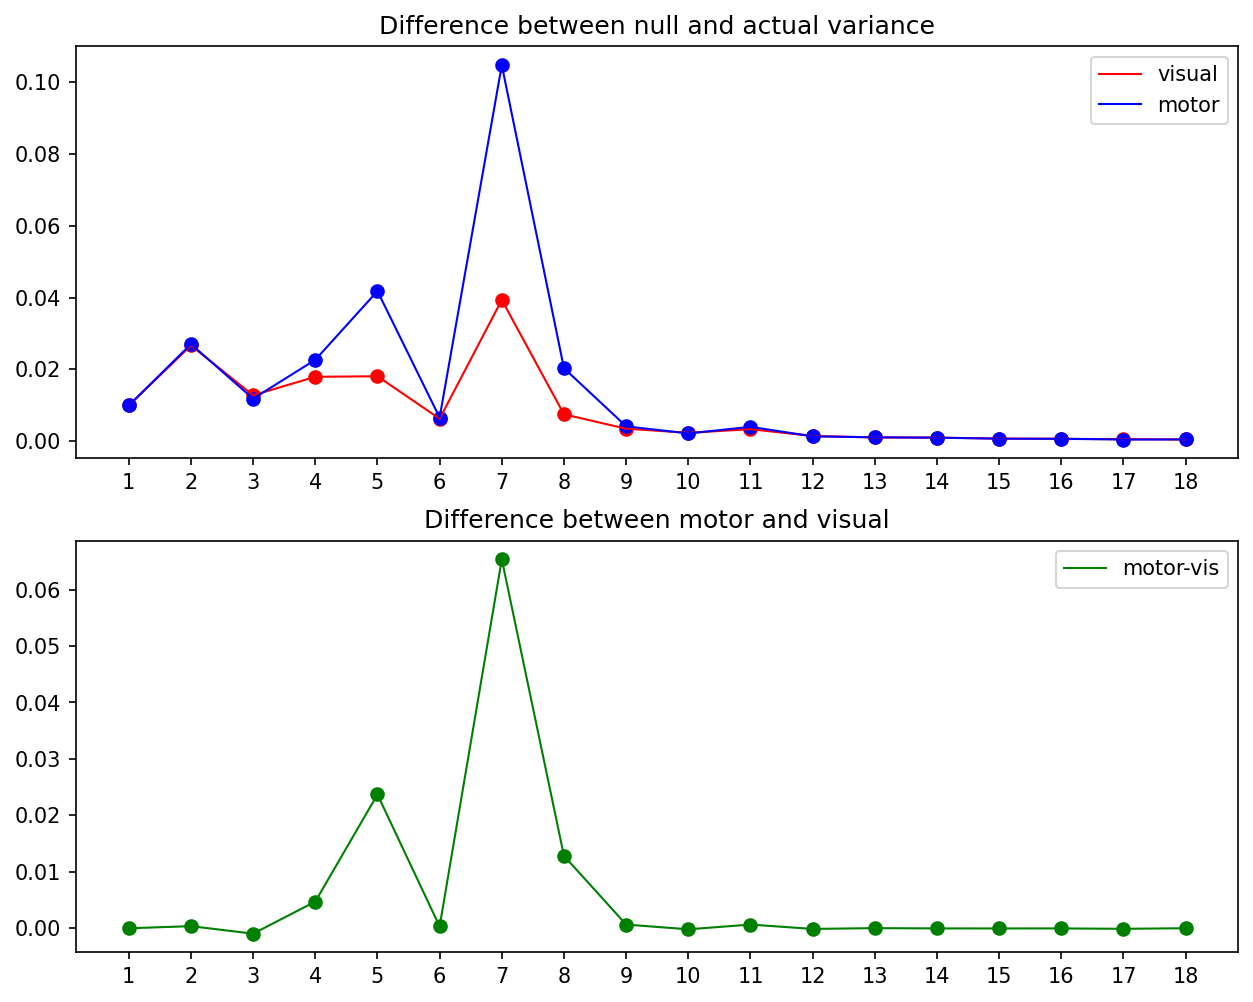

In [101]:
comp_var_mot = []
comp_var_vis = []
null_var_mot = []
null_var_vis = []
for ix, comp in enumerate(range(PCS_to_analyse)):
    vis_avg_tc = []
    mot_avg_tc = []
    for s in list(sub_metrics.keys()):
        vis_avg_tc.append(np.var(nice_results[s][comp]["vis"]))
        mot_avg_tc.append(np.var(nice_results[s][comp]["mot"]))
    comp_var_vis.append(np.mean(vis_avg_tc, axis=0))
    comp_var_mot.append(np.mean(mot_avg_tc, axis=0))

comp_var_mot = np.array(comp_var_mot)
comp_var_vis = np.array(comp_var_vis)

comps = np.arange(PCS_to_analyse) + 1

f, ax = plt.subplots(2, 1, figsize=(10, 8), facecolor="white", dpi=150)
ax[0].plot(comps, comp_var_vis, lw=1, c="red", alpha=1, label="visual")
ax[0].scatter(comps, comp_var_vis, lw=1, c="red", alpha=1)
ax[0].plot(comps, comp_var_mot, lw=1, c="blue", alpha=1, label="motor")
ax[0].scatter(comps, comp_var_mot, lw=1, c="blue", alpha=1)
ax[0].set_xticks(comps)
ax[0].legend()
ax[0].set_title("Difference between null and actual variance")

ax[1].plot(comps, comp_var_mot - comp_var_vis, lw=1, c="green", alpha=1, label="motor-vis")
ax[1].scatter(comps, comp_var_mot - comp_var_vis, lw=1, c="green", alpha=1)
ax[1].set_xticks(comps)
ax[1].legend()
ax[1].set_title("Difference between motor and visual")

In [13]:
time_buf = 0.125
bin_width = 0.05
smooth_kernel_size = 1
vis_time_bins = np.arange(visual_epo_times[0]+time_buf, visual_epo_times[-1]-time_buf, bin_width)
mot_time_bins = np.arange(motor_epo_times[0]+time_buf, motor_epo_times[-1]-time_buf, bin_width)

burst_base_bins = np.where(vis_time_bins<0)[0]

base_results_all = {"vis": [], "mot": []}


for sub in tqdm(sub_metrics.keys()):
    trials_vis = np.unique(sub_metrics[sub]["vis"]["pp_ix"])
    trials_mot = np.unique(sub_metrics[sub]["mot"]["pp_ix"])
    
    mv_burst_rate = []
    for ix, t_ix in enumerate(trials_vis):
        ixes = np.where(sub_metrics[sub]["vis"]["pp_ix"] == t_ix)
        mv_hist, t_bin_edges = np.histogram(
            sub_metrics[sub]["vis"]["peak_time"][ixes],
            bins=vis_time_bins
        )
        mv_hist = mv_hist / bin_width
        mv_burst_rate.append(gaussian_filter(mv_hist, smooth_kernel_size))
    mv = np.mean(mv_burst_rate, axis=0)

    mm_burst_rate = []
    for ix, t_ix in enumerate(trials_mot):
        ixes = np.where(sub_metrics[sub]["mot"]["pp_ix"] == t_ix)
        mm_hist, t_bin_edges = np.histogram(
            sub_metrics[sub]["mot"]["peak_time"][ixes],
            bins=mot_time_bins
        )
        mm_hist = mm_hist / bin_width
        mm_burst_rate.append(gaussian_filter(mm_hist, smooth_kernel_size))
    mm = np.mean(mm_burst_rate,axis=0)

    base_bursts = np.mean(mv[burst_base_bins[1:]])
    mv = (mv - base_bursts) / base_bursts
    mm = (mm - base_bursts) / base_bursts

    base_results_all["vis"].append(mv)
    base_results_all["mot"].append(mm)

  0%|          | 0/36 [00:00<?, ?it/s]

(-0.21951024026910895, 0.07883776511084593)

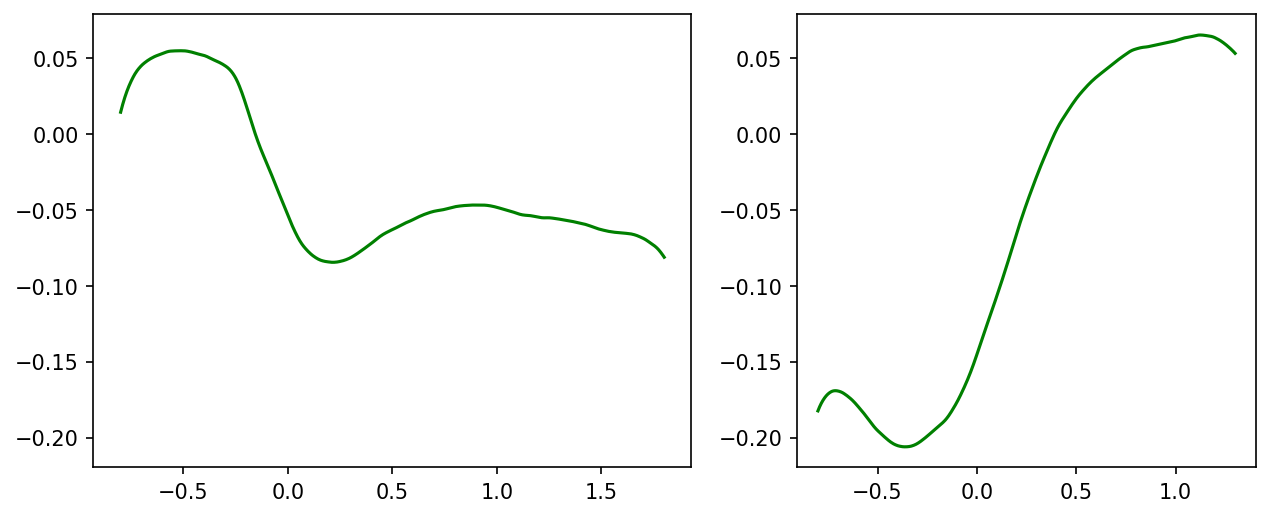

In [73]:
good_ixs = np.where(np.var(vis_bt, axis=1) < 0.1)[0]

f, ax = plt.subplots(1, 2, figsize=(10, 4), facecolor="white", dpi=150, gridspec_kw={'width_ratios': [2.15, 1.65]})
ixs_v = np.where(visual_epo_times >= -0.8)[0][:-120]
ixs_m = np.where(motor_epo_times >= -0.8)[0][:-120]
vis_bt = np.array(beta["vis"])[good_ixs,:]
mot_bt = np.array(beta["mot"])[good_ixs,:]
vis_bt_mean = np.mean(vis_bt, axis=0)[ixs_v]
mot_bt_mean = np.mean(mot_bt, axis=0)[ixs_m]
vis_bt_sem = np.std(vis_bt, axis=0)[ixs_v]/np.sqrt(36)
mot_bt_sem = np.std(mot_bt, axis=0)[ixs_m]/np.sqrt(36)

ax[0].plot(visual_epo_times[ixs_v], vis_bt_mean, c="green")

ax[1].plot(motor_epo_times[ixs_m], mot_bt_mean, c="green")


lims = [
    np.min(np.array([ax[0].get_ylim()[0], ax[1].get_ylim()[0]]).flatten()),
    np.max(np.array([ax[0].get_ylim()[1], ax[1].get_ylim()[1]]).flatten())
]

ax[0].set_ylim(lims)
ax[1].set_ylim(lims)

(36, 1801)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_63220/604794960.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


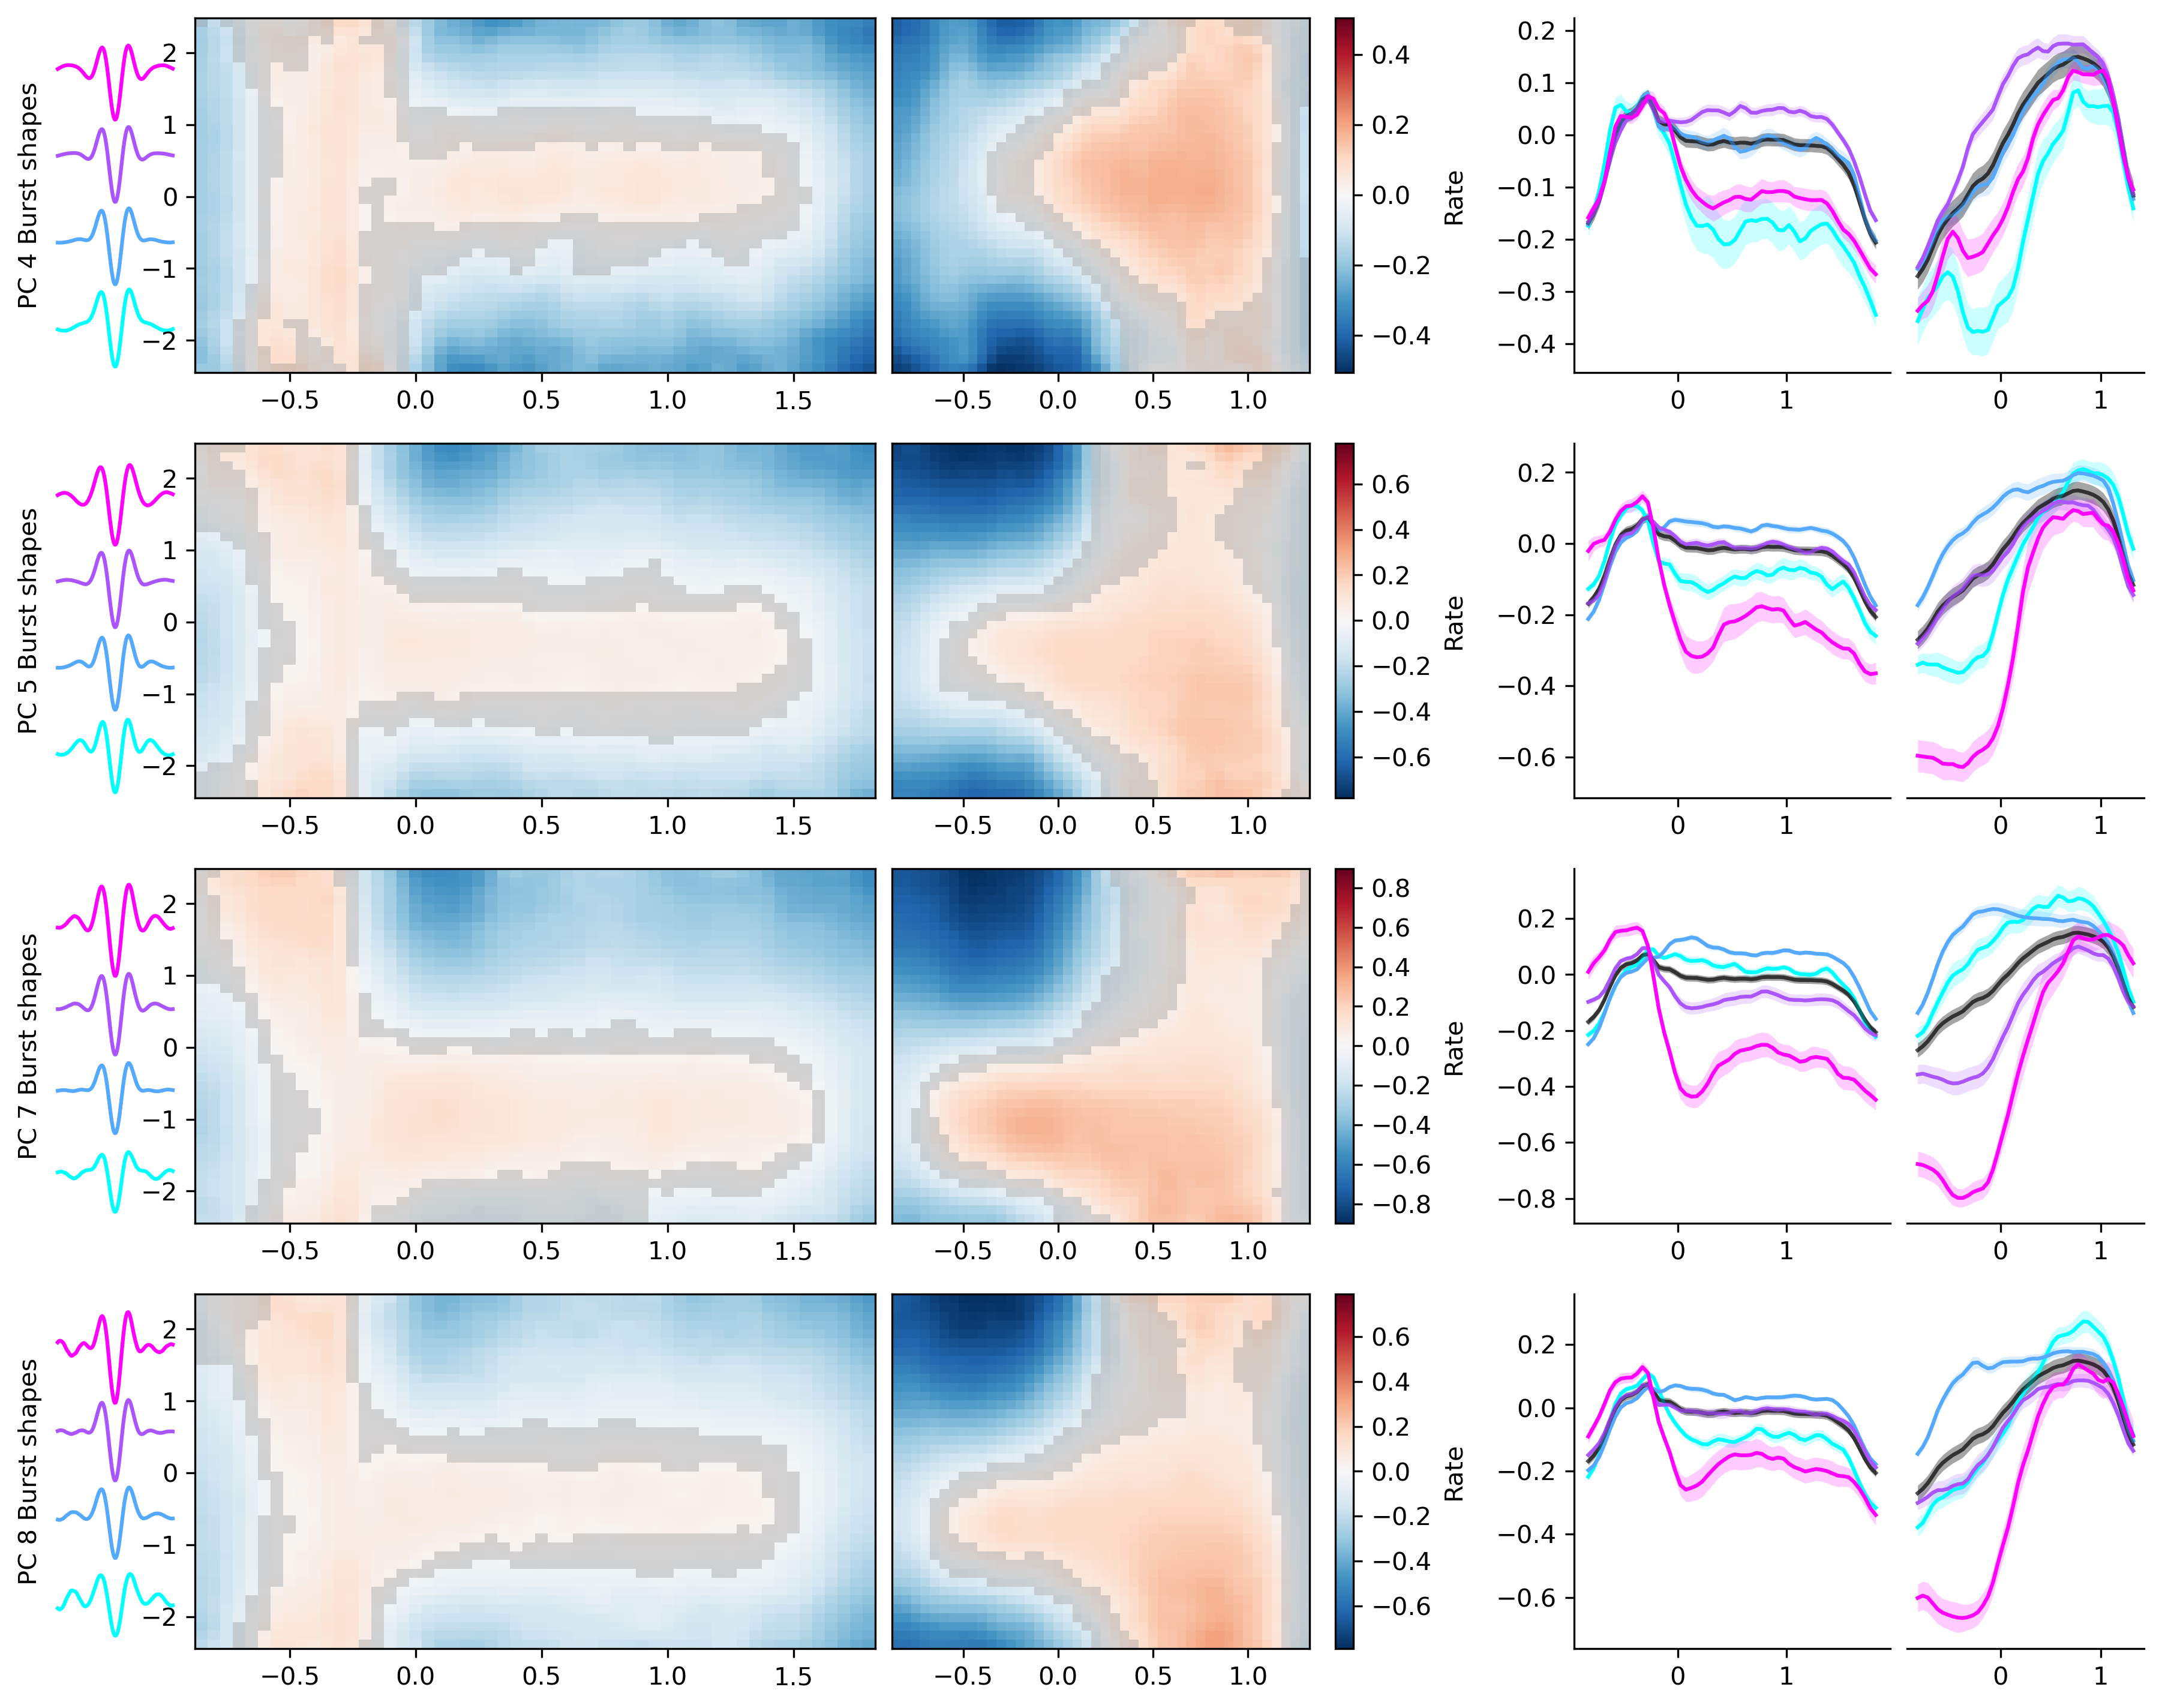

In [79]:
vis = np.array(base_results_all["vis"])
vis_sem = np.std(vis)/np.sqrt(36)
mot = np.array(base_results_all["mot"])
mot_sem = np.std(mot)/np.sqrt(36)


threshold_tfce = dict(start=0, step=0.2)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)


numx = [3, 4, 6, 7]
# numx = 2
f, ax = plt.subplots(len(numx), 6, figsize=(15, len(numx)*3), facecolor="white", dpi=300, gridspec_kw={'width_ratios': [0.4, 2.15, 1.65, 0.4, 1, 0.75], "wspace": 0.05})
for comp_ix in trange(len(numx)):
    comp = numx[comp_ix]
    mv_a = np.array(results_all[str(comp)]["vis"])
    mm_a = np.array(results_all[str(comp)]["mot"])

    #### STAAATS
    # stats TFCE + "hat" variance adjustment + FWER https://doi.org/10.1016/j.neuroimage.2011.10.027
    # https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html#visualize-and-compare-methods
    # Clustering with TFCE and "hat" variance adjustment narrows down the area declared significant

    mv_T_HAT, _, mv_P_HAT, _ = permutation_cluster_1samp_test(
        mv_a, stat_fun = hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    mv_mask = np.reshape(mv_P_HAT, mv.shape).T
    mv_mask[mv_mask >= 0.05] = 1
    mv_mask[mv_mask < 0.05] = np.nan
    
    mm_T_HAT, _, mm_P_HAT, _ = permutation_cluster_1samp_test(
        mm_a, stat_fun=hat_corr,
        threshold = threshold_tfce, n_permutations=1000, n_jobs=1,
        out_type="mask", verbose=False, adjacency=None, buffer_size=None
    )
    
    mm_mask = np.reshape(mm_P_HAT, mm.shape).T
    mm_mask[mm_mask >= 0.05] = 1
    mm_mask[mm_mask < 0.05] = np.nan
    ####

    mv = np.mean(mv_a, axis=0)
    mm = np.mean(mm_a, axis=0)
        
    all_burst_im = np.vstack([mv, mm])
    lims = [-np.max(np.abs(all_burst_im[:])), np.max(np.abs(all_burst_im[:]))]
    divnorm = colors.TwoSlopeNorm(vmin=lims[0], vcenter=0, vmax=lims[1])
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    
    for key, spine in ax[comp_ix, 0].spines.items():
        spine.set_visible(False)
    ax[comp_ix, 0].set_yticks([])
    ax[comp_ix, 0].set_xticks([])
    ax[comp_ix, 0].set_ylabel("PC {} Burst shapes".format(comp+1))

    col_r = plt.cm.cool(np.linspace(0,1,4))
    poss = np.linspace(int(score_range[0])+0.25, int(score_range[-1])-0.25, 4)
    ft = np.linspace(score_range[0], score_range[-1], num=40)
    for ixxx, pos in enumerate(poss):
        burst_shape = (norm_mean + pos * pca_full.components_[comp,:]) / 2.5 + pos
        ax[comp_ix, 0].plot(burst_times, burst_shape, c=col_r[ixxx])
        
        mxixx = np.where(ft < pos)[0][-1]
        mx_v_x = mv_a[:, :, mxixx]
        mx_m_x = mm_a[:, :, mxixx]
#         mx_v_m = np.mean(mx_v_x, axis=0)+pos
#         mx_m_m = np.mean(mx_m_x, axis=0)+pos
        mx_v_m = np.mean(mx_v_x, axis=0)
        mx_m_m = np.mean(mx_m_x, axis=0)
        mx_v_sem = np.std(mv_a[:, :, mxixx], axis=0) / np.sqrt(36)
        mx_m_sem = np.std(mm_a[:, :, mxixx], axis=0) / np.sqrt(36)

        ax[comp_ix, 4].plot(vis_time_bins[1:], np.mean(vis, axis=0),c="black", alpha=0.25)
        ax[comp_ix, 4].fill_between(vis_time_bins[1:], np.mean(vis, axis=0) - vis_sem, np.mean(vis, axis=0) + vis_sem, color="black", lw=0, alpha=0.1)      

        ax[comp_ix, 5].plot(mot_time_bins[1:], np.mean(mot, axis=0),c="black", alpha=0.25)
        ax[comp_ix, 5].fill_between(mot_time_bins[1:], np.mean(mot, axis=0) - mot_sem, np.mean(mot, axis=0) + mot_sem, color="black", lw=0, alpha=0.1)

        
        ax[comp_ix, 4].plot(vis_time_bins[1:], mx_v_m, c=col_r[ixxx])
        ax[comp_ix, 4].fill_between(vis_time_bins[1:], mx_v_m - mx_v_sem, mx_v_m + mx_v_sem, color=col_r[ixxx], alpha=0.2, lw=0)
        
        ax[comp_ix, 5].plot(mot_time_bins[1:], mx_m_m, c=col_r[ixxx])
        ax[comp_ix, 5].fill_between(mot_time_bins[1:], mx_m_m - mx_m_sem, mx_m_m + mx_m_sem, color=col_r[ixxx], alpha=0.2, lw=0)
                
#         ax[comp_ix, 3].axhline(pos, c="black", lw=0.2)
#         ax[comp_ix, 4].axhline(pos, c="black", lw=0.2)
        
    ax[comp_ix, 0].set_ylim(score_range[0], score_range[-1])
    
    v_im = ax[comp_ix, 1].imshow(mv.T, cmap="RdBu_r", origin="lower", norm=divnorm, extent=[vis_time_bins[0], vis_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none", rasterized=True)
    ax[comp_ix, 1].imshow(mv_mask,cmap="gray_r", origin="lower", norm=graynorm, extent=[vis_time_bins[0], vis_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    
    m_im = ax[comp_ix, 2].imshow(mm.T, cmap="RdBu_r", origin="lower", norm=divnorm, extent=[mot_time_bins[0], mot_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none", rasterized=True)
    ax[comp_ix, 2].imshow(mm_mask,cmap="gray_r", origin="lower", norm=graynorm, extent=[mot_time_bins[0], mot_time_bins[-1], score_range[0], score_range[-1]], aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

    ax[comp_ix, 2].set_yticks([])

    
    for key, spine in ax[comp_ix, 4].spines.items():
        if key in ["top", "right"]:
            spine.set_visible(False)
    
    for key, spine in ax[comp_ix, 5].spines.items():
        if key in ["top", "right", "left"]:
            spine.set_visible(False)

    ax[comp_ix, 5].set_yticks([])

    cbar = plt.colorbar(m_im, ax=ax[comp_ix, 2])
    cbar.set_label("Rate", rotation=90)
    
    ax[comp_ix, 3].set_visible(False)
    lims = [
        np.min(np.array([ax[comp_ix, 4].get_ylim()[0], ax[comp_ix, 5].get_ylim()[0]]).flatten()),
        np.max(np.array([ax[comp_ix, 4].get_ylim()[1], ax[comp_ix, 5].get_ylim()[1]]).flatten())
    ]
    
    ax[comp_ix, 4].set_ylim(lims)
    ax[comp_ix, 5].set_ylim(lims)
    
    

plt.tight_layout()
plt.savefig("FIG_05_BURST_SUMMARY_final_final_final.svg")

In [38]:
with open('beta_result.json') as f:
   beta = json.load(f)

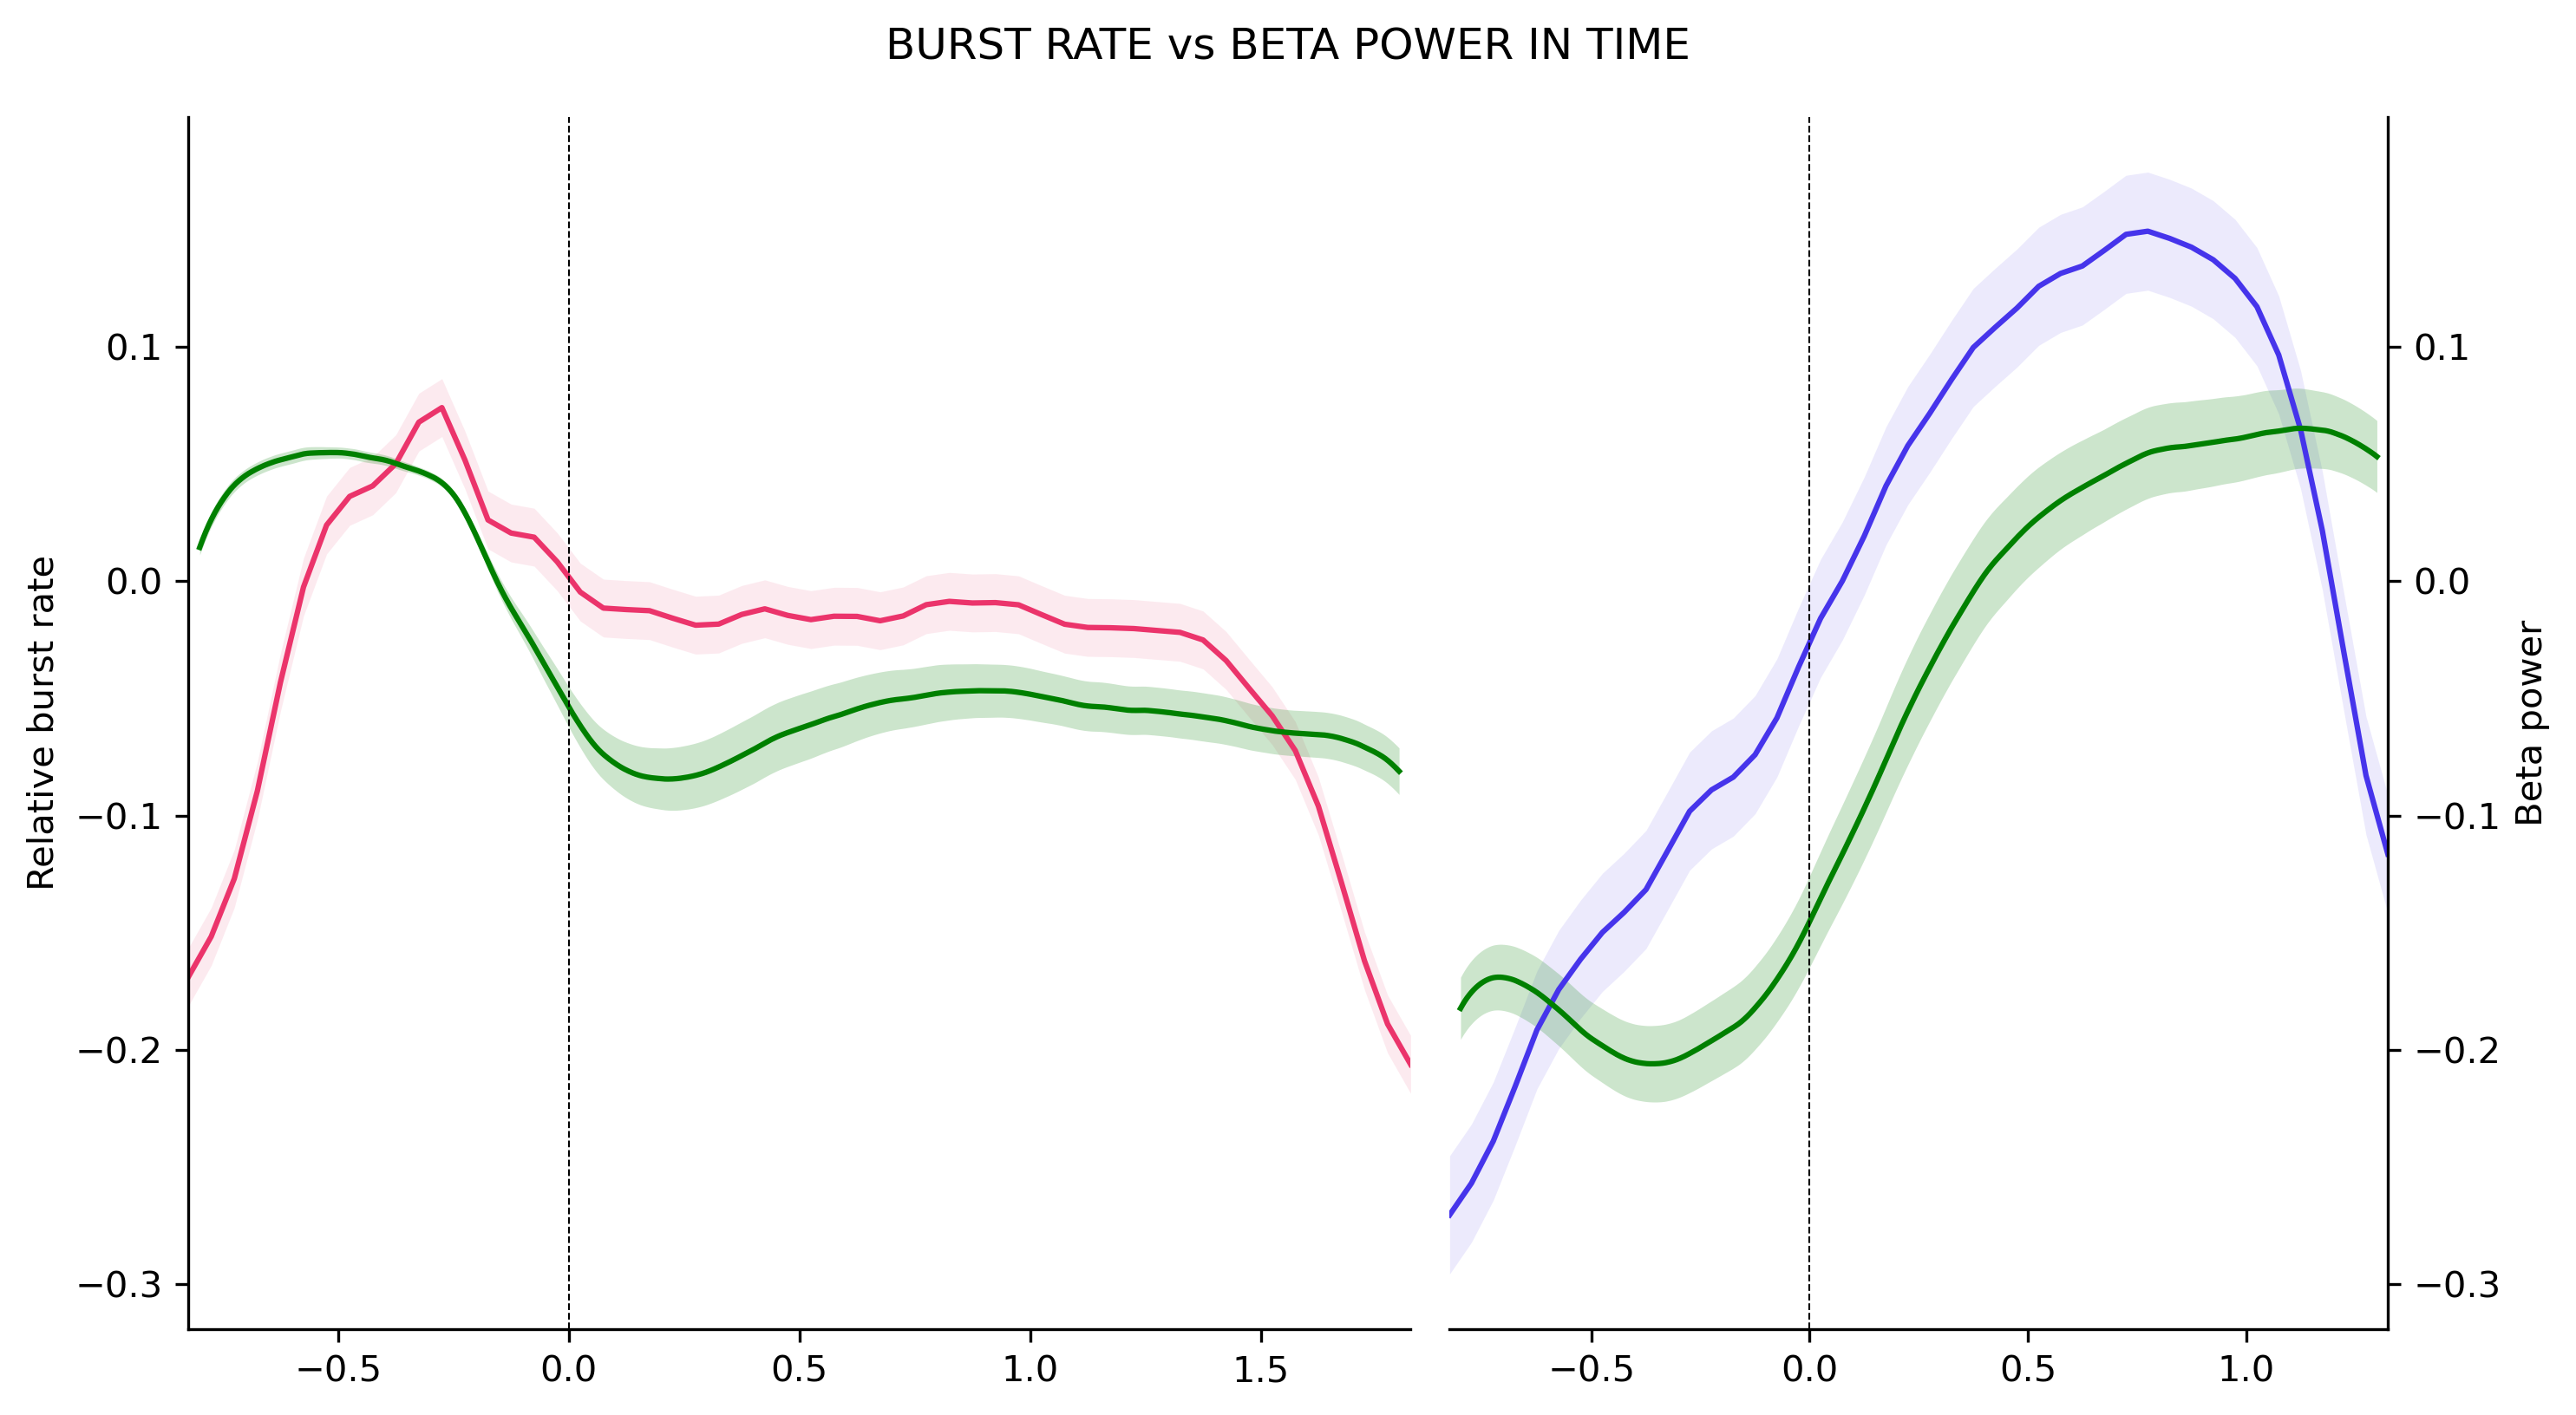

In [78]:
cw_m = "#4634eb"
cw_v = "#eb346b"


f, ax = plt.subplots(1, 2, figsize=(10,5.5), dpi=300, facecolor="white", gridspec_kw={'width_ratios': [2.15, 1.65]})

ax[0].plot(vis_time_bins[1:], np.mean(vis, axis=0),c=cw_v, alpha=1)
ax[0].fill_between(vis_time_bins[1:], np.mean(vis, axis=0) - vis_sem, np.mean(vis, axis=0) + vis_sem, color=cw_v, lw=0, alpha=0.1)      

ax[1].plot(mot_time_bins[1:], np.mean(mot, axis=0),c=cw_m, alpha=1)
ax[1].fill_between(mot_time_bins[1:], np.mean(mot, axis=0) - mot_sem, np.mean(mot, axis=0) + mot_sem, color=cw_m, lw=0, alpha=0.1)      

ax[0].plot(visual_epo_times[ixs_v], vis_bt_mean, c="green")
ax[0].fill_between(visual_epo_times[ixs_v], vis_bt_mean-vis_bt_sem, vis_bt_mean+vis_bt_sem, alpha=0.2, lw=0, color="green")

ax[1].plot(motor_epo_times[ixs_m], mot_bt_mean, c="green")
ax[1].fill_between(motor_epo_times[ixs_m], mot_bt_mean-mot_bt_sem, mot_bt_mean+mot_bt_sem, alpha=0.2, lw=0, color="green")

lims = np.array([list(ax[0].get_ylim()), list(ax[1].get_ylim())]).flatten()

ax[0].set_ylim(np.min(lims), np.max(lims))
ax[1].set_ylim(np.min(lims), np.max(lims))

ax[0].set_xlim(vis_time_bins[1], vis_time_bins[-1])
ax[1].set_xlim(mot_time_bins[1], mot_time_bins[-1])

ax[0].axvline(0, lw=0.5, c="black", linestyle="--")
ax[1].axvline(0, lw=0.5, c="black", linestyle="--")

ax[0].set_xticks([-0.5, 0.0, 0.5, 1.0, 1.5])
ax[1].set_xticks([-0.5, 0.0, 0.5, 1.0])

ax[1].yaxis.set_ticks_position("right")
ax[1].yaxis.set_label_position("right")

ax[0].set_ylabel("Relative burst rate")
ax[1].set_ylabel("Beta power")

for key, spine in ax[0].spines.items():
    if key in ["top", "right"]:
        spine.set_visible(False)

for key, spine in ax[1].spines.items():
    if key in ["top", "left"]:
        spine.set_visible(False)

f.suptitle("BURST RATE vs BETA POWER IN TIME")
plt.tight_layout()
plt.savefig("FIG_02_BURST_RATE_IN_TIME.svg")

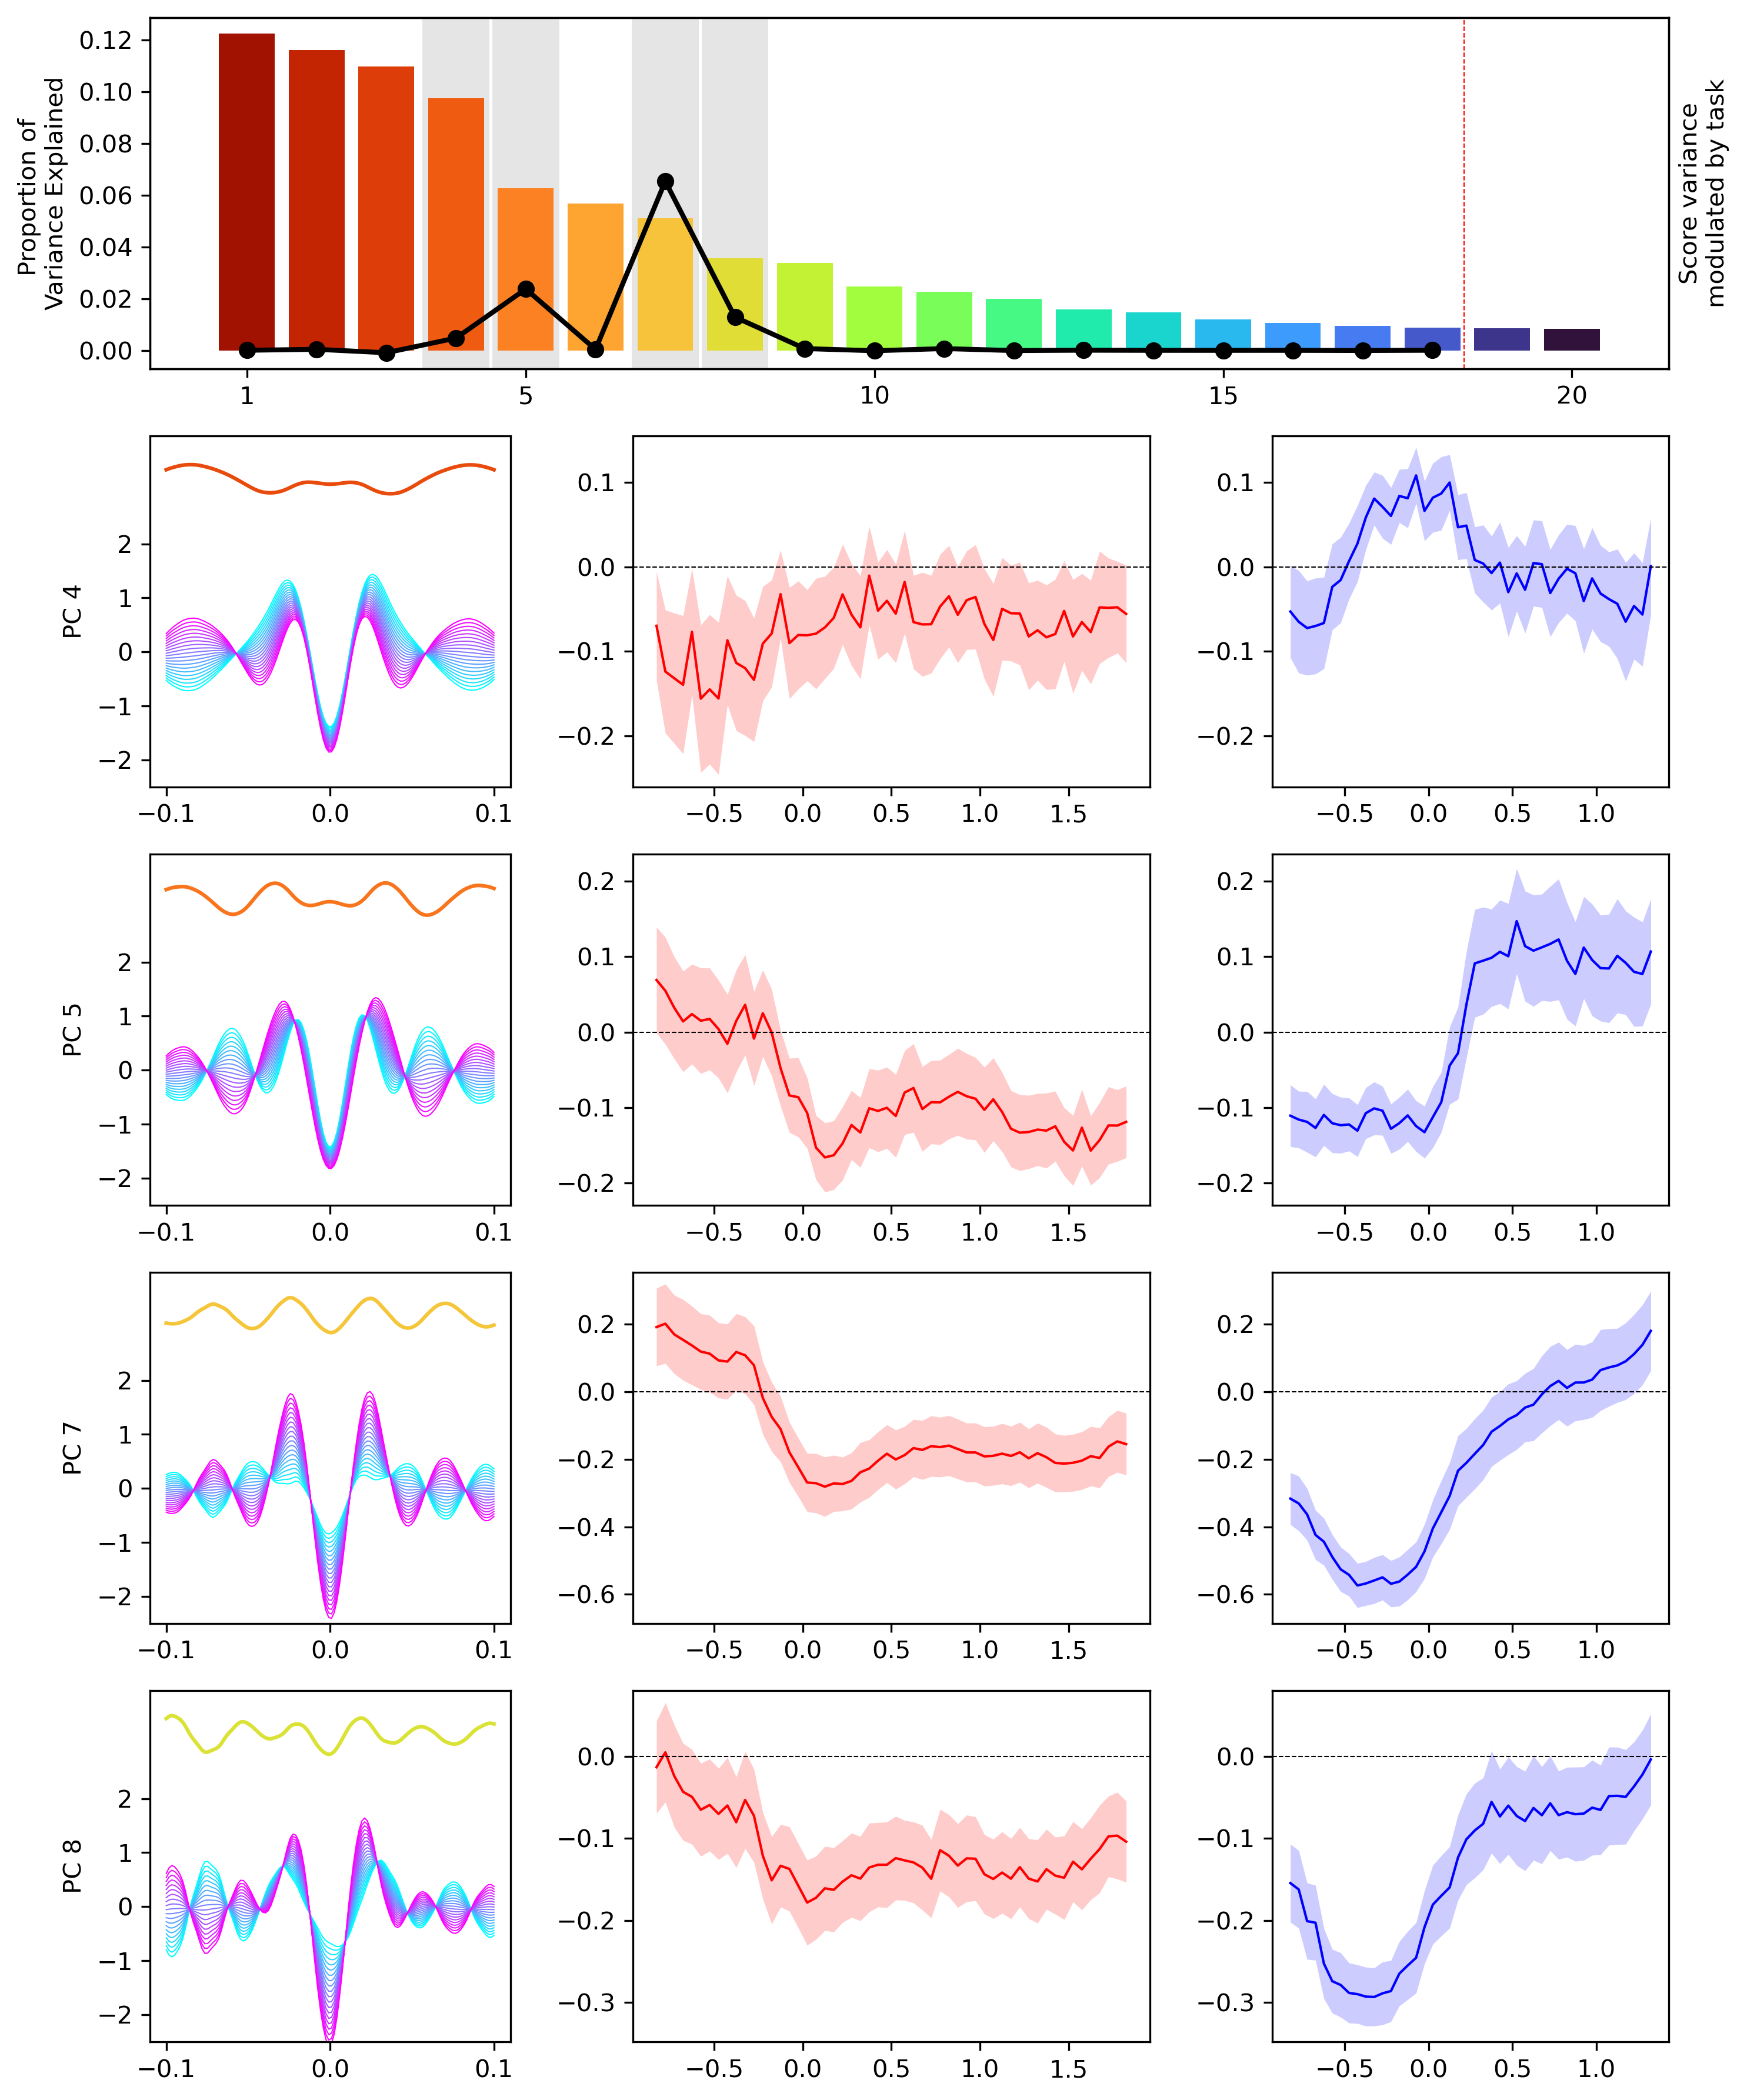

In [166]:
edge_size = int(np.round(np.sqrt(22), 0))
positions = list(it.product(range(edge_size),range(edge_size)))
to_remove = list(it.product(range(edge_size),range(edge_size)))

norm_mean = mean_waveform/np.max(mean_waveform)
in_comp_am = 20
component_space = np.linspace(-5,5,in_comp_am)
colour_range = plt.cm.cool(np.linspace(0,1,in_comp_am))
score_range = plt.cm.turbo_r(np.linspace(0,1,PCS_to_analyse))


var_full = pca_full.explained_variance_ratio_

f, ax = plt.subplots(5, 3, figsize=(10,12), dpi=300, facecolor="white", gridspec_kw={'width_ratios': [1.5, 2.15, 1.65]})

for ix_c, PC in enumerate([3, 4, 6, 7]):
    ix_c = ix_c+1
    ax[ix_c,0].set_ylabel("PC {}".format(PC+1))
    ax[ix_c,0].set_yticks([-2, -1, 0, 1, 2])
    ax[ix_c,0].set_ylim(-2.5, 4)
    ax[ix_c,0].plot(burst_times, 3.2 + 2*pca_full.components_[PC,:], lw=1.5, c=score_range[PC])
    for ix, sub_comp in enumerate(component_space):
        sub_comp_value = norm_mean + sub_comp * pca_full.components_[PC,:]
        ax[ix_c,0].plot(burst_times, sub_comp_value, lw=0.5, color=colour_range[ix])
    vis_arr = []
    mot_arr = []
    for s in list(sub_metrics.keys()):
        vis_arr.append(nice_results[s][PC]["vis"])
        mot_arr.append(nice_results[s][PC]["mot"])
    vis_arr = np.vstack(vis_arr)
    mot_arr = np.vstack(mot_arr)
    vis_mean = np.mean(vis_arr, axis=0)
    mot_mean = np.mean(mot_arr, axis=0)
    vis_sem = np.std(vis_arr, axis=0)/np.sqrt(36)
    mot_sem = np.std(mot_arr, axis=0)/np.sqrt(36)
    
    ax[ix_c, 1].plot(vis_time_bins[1:], vis_mean, c="red", lw=1, alpha=1)
    ax[ix_c, 1].fill_between(vis_time_bins[1:], vis_mean-vis_sem, vis_mean+vis_sem, color="red", lw=0, alpha=0.2)
    
    ax[ix_c, 2].plot(mot_time_bins[1:], mot_mean, c="blue", lw=1, alpha=1)
    ax[ix_c, 2].fill_between(mot_time_bins[1:], mot_mean-mot_sem, mot_mean+mot_sem, color="blue", lw=0, alpha=0.2)
    
    lims = [
        np.min(np.array([ax[ix_c, 1].get_ylim()[0], ax[ix_c, 2].get_ylim()[0]]).flatten()),
        np.max(np.array([ax[ix_c, 1].get_ylim()[1], ax[ix_c, 2].get_ylim()[1]]).flatten())
    ]
    ax[ix_c, 1].set_ylim(lims)
    ax[ix_c, 2].set_ylim(lims)
    
    ax[ix_c, 1].axhline(0, linestyle="--", lw=0.5, c="black")
    ax[ix_c, 2].axhline(0, linestyle="--", lw=0.5, c="black")
    
#     for key, spine in ax[ix_c, 0].spines.items():
#         if key in ["top", "right"]:
#             spine.set_visible(False)
    
#     for key, spine in ax[ix_c, 1].spines.items():
#         if key in ["right"]:
#             spine.set_visible(False)

#     for key, spine in ax[ix_c, 2].spines.items():
#         if key in ["left"]:
#             spine.set_visible(False)
#     ax[ix_c, 2].yaxis.set_ticks_position("right")
#     ax[ix_c, 2].yaxis.set_label_position("right")
#     ax[ix_c, 1].set_yticks([])

gc = ax[0,0].get_gridspec()
for col in range(3):
    ax[0, col].remove()

pca_bit = f.add_subplot(gc[0,:3])

PC_r = np.arange(20) + 1
bar = pca_bit.bar(PC_r, var_full, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
# pca_bit.set_xlabel("Principal Component")
pca_bit.set_ylabel("Proportion of \nVariance Explained")
pca_bit.axvline(PCS_to_analyse+0.45, linestyle="dashed", c="red", lw=0.5)
pca_bit.set_xticks([1, 5, 10, 15, 20])


pca_bit.plot(comps, comp_var_mot - comp_var_vis, lw=2, c="black")
pca_bit.scatter(comps, comp_var_mot - comp_var_vis, c="black", zorder=3)
for x in [4, 5, 7, 8]:
    pca_bit.axvspan(x-0.48, x+0.48, color="gray", alpha=0.2, zorder=-3, lw=0)
pca_bit2 = pca_bit.twinx()
pca_bit2.set_ylabel("Score variance\nmodulated by task")
pca_bit2.set_yticks([])
plt.tight_layout()
plt.savefig("FIG_04_PCA_SMASHFEST.svg")